In [1]:
from extract_relations import get_directed_relations, order_directed_relations
from ontology_algorithm import construct_ontology_hierarchy, draw_hierarchy_tree_from_ontology
from topic_modeling import kmeans_tfidf_clustering
from preprocessing import get_word_types_with_tf_idf
import pandas as pd

In [2]:
# Preprocessing stage

# read csv file and drop any N/A rows from the dataframe 
# note to self: can I also use DEBRA for song lyrics depending on how I break it up?
df = pd.read_csv("../data/data_structures.csv").dropna()

# generate unique list of chapter titles 
chapter_titles = df["chapter-title"].unique()

# generate list of each chapters text
chapter_texts = []
sentences_per_chapter = []
temp = []
text = ''
for chapter in df["chapter"].unique():
    chapter_df = df.query(f'chapter == "{chapter}"')
    text = ''
    temp = []
    for chapter_text in chapter_df["text"].values:
        text += chapter_text + ' '
        temp.append(chapter_text)
    chapter_texts.append(text)
    sentences_per_chapter.append(temp)

In [3]:
chapter_titles

array(['Data Structures and Algorithms', 'Mathematical Preliminaries',
       'Algorithm Analysis', 'Lists, Stacks, and Queues', 'Binary Trees',
       'Non-Binary Trees', 'Internal Sorting',
       'File Processing and External Sorting', 'Searching', 'Indexing',
       'Graphs', 'Lists and Arrays Revisited', 'Advanced Tree Structures',
       'Analysis Techniques', 'Lower Bounds', 'Patterns of Algorithms',
       'Limits to Computation'], dtype=object)

In [5]:
# topic modeling 
# the kmeans_tfidf_clustering function also includes the TF-IDF vectorization stage as well,
# which is part of the preprocessing stage in DEBRA's architecture 

num_topics = 10 # how many number of topics should I have relative to number of chapters? 
clusters, cluster_terms = kmeans_tfidf_clustering(chapters = chapter_texts, num_topics = num_topics)

CLUSTER #1
Cluster Chapters: [0]
Key Features: ['design', 'data structure', 'structure', 'type', 'program', 'data type', 'design patterns', 'activity', 'adt', 'algorithms', 'computer', 'design pattern', 'rendering', 'data item', 'data structures', 'structures', 'pattern', 'chap data', 'data items', 'constraints', 'operations', 'objects', 'account', 'patterns', 'database', 'collection', 'programs', 'object', 'physical', 'structures algorithms', 'programming', 'page', 'visitor', 'integers', 'customers', 'object oriented', 'implementation', 'oriented', 'accounts', 'different', 'queries', 'problems', 'sorting', 'types', 'activities', 'exact match', 'subclass', 'instance', 'output', 'tree']
CLUSTER #2
Cluster Chapters: [4, 5, 9, 12]
Key Features: ['tree', 'node', 'nodes', 'child', 'figure', 'leaf', 'root', 'rt', 'trees', 'internal', 'children', 'binary', 'subtree', 'bst', 'parent', 'binary tree', 'records', 'right', 'record', 'search', 'binary trees', 'figure 13', 'quadtree', 'general tree'

In [12]:
clusters

{1: [0],
 2: [4, 5, 9, 12],
 3: [16],
 4: [1, 13],
 5: [2, 6, 14],
 6: [7, 11],
 7: [10],
 8: [3],
 9: [8],
 10: [15]}

In [14]:
cluster = 5
cluster_chapters = clusters[cluster]
cluster_chapter_titles = [chapter_titles[i] for i in cluster_chapters]
cluster_chapter_titles

['Algorithm Analysis', 'Internal Sorting', 'Lower Bounds']

/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tf = pd.concat([tf, row_df], ignore_index=True)
/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  idf = pd.concat([idf, row_df], ignore_index=True)


Cluster #4, cluster chapters are [11]


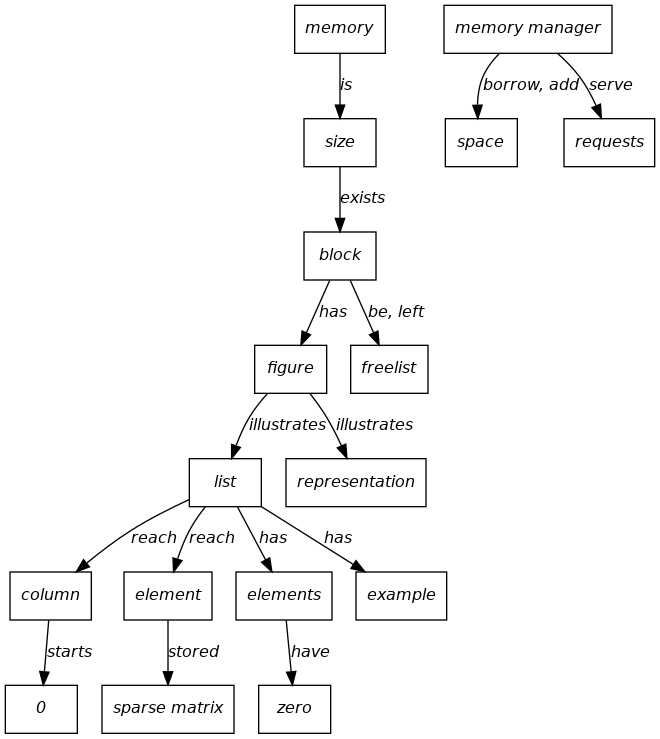

In [5]:
cluster = 4
cluster_chapters = clusters[cluster]
cluster_chapter_titles = [chapter_titles[i] for i in cluster_chapters]
key_terms = cluster_terms[cluster]

text_per_chapter = []
for index in cluster_chapters:
    text_per_chapter.append(chapter_texts[index])
    
pre_filtering = get_word_types_with_tf_idf(text_per_chapter, "tf", skip_stopwords = True, include_verbs = False, include_determiners = False, include_pronouns = False, include_adverbs = False, include_numbers = True)

all_verses = []
for chapter_idx in cluster_chapters:
    all_verses.extend(sentences_per_chapter[chapter_idx])

top_words = pre_filtering.head(50)['word'].values

print(f'Cluster #{cluster}, cluster chapters are {cluster_chapters}')
directed_relations, relations_to_verbs = get_directed_relations(
    top_n_words=top_words,
    all_verses=all_verses,
    only_compounds=True,
    verbose=False,
)

ordered_directed_relations = order_directed_relations(
    directed_relations=directed_relations,
    tf_idf_pre_filtering=pre_filtering,
    order_by="tf_idf",
    include_ordering_wrt_occurences=True,
    verbose=False,
)

ontology_hierarchy, words_with_parents = construct_ontology_hierarchy(
    ordered_directed_relations=ordered_directed_relations,
)

draw_hierarchy_tree_from_ontology(
    ontological_hierarchy=ontology_hierarchy,
    relations_to_verbs=relations_to_verbs
)

In [6]:
# import spacy (natural language processing library)
import spacy 

# load spacy model
nlp = spacy.load("en_core_web_lg")
chapter = 16 # value 0 - 16
sentence = 3
doc = nlp(sentences_per_chapter[chapter][sentence])

# displaying word relations using user number
spacy.displacy.render(doc, style = 'dep', jupyter = True)

Cluster: #1, cluster chapters: [0], chapter names: ['Data Structures and Algorithms']


/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tf = pd.concat([tf, row_df], ignore_index=True)
/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  idf = pd.concat([idf, row_df], ignore_index=True)


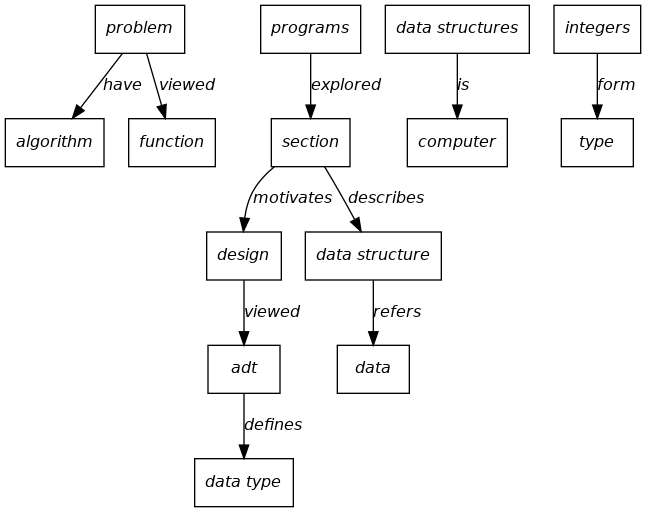

Cluster: #2, cluster chapters: [4, 5, 9, 12], chapter names: ['Binary Trees', 'Non-Binary Trees', 'Indexing', 'Advanced Tree Structures']


/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tf = pd.concat([tf, row_df], ignore_index=True)
/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  idf = pd.concat([idf, row_df], ignore_index=True)


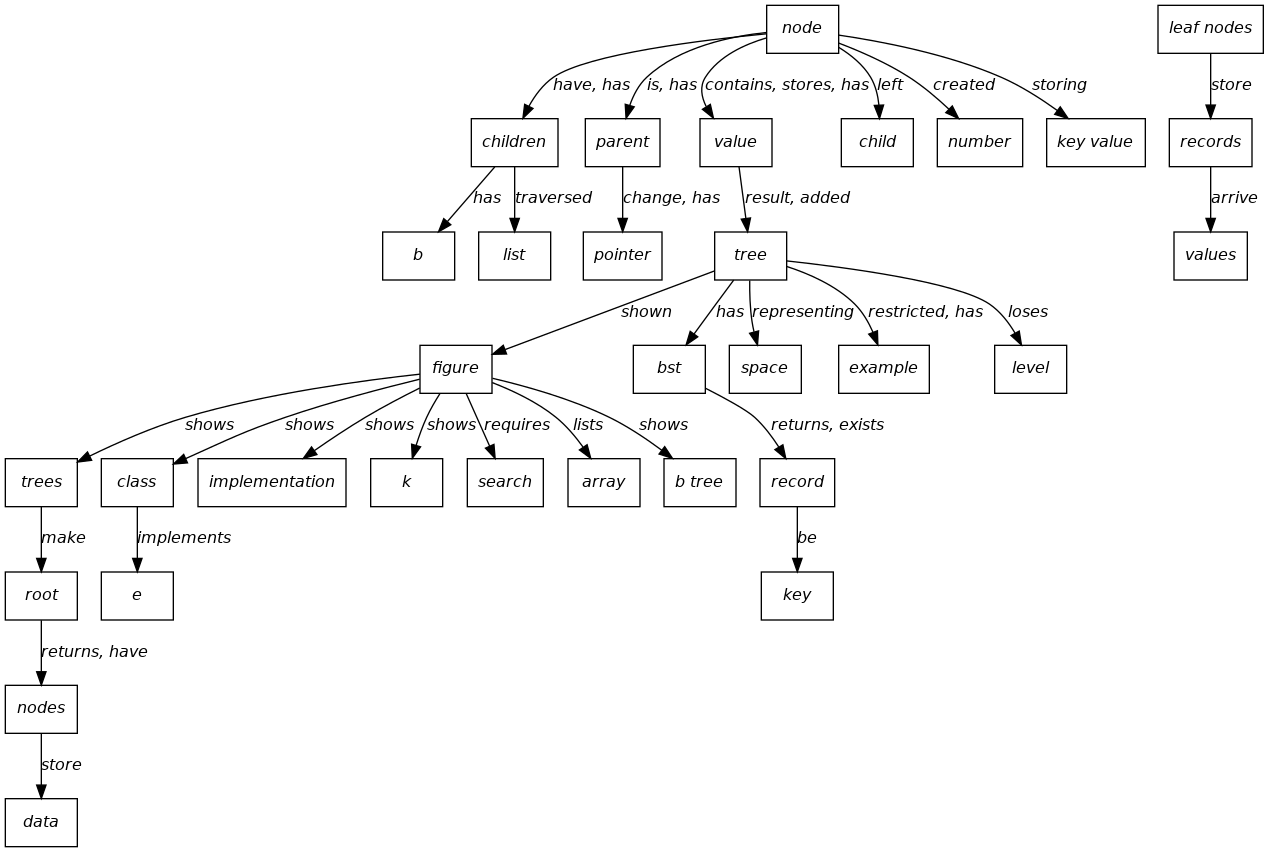

Cluster: #3, cluster chapters: [16], chapter names: ['Limits to Computation']


/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tf = pd.concat([tf, row_df], ignore_index=True)
/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  idf = pd.concat([idf, row_df], ignore_index=True)


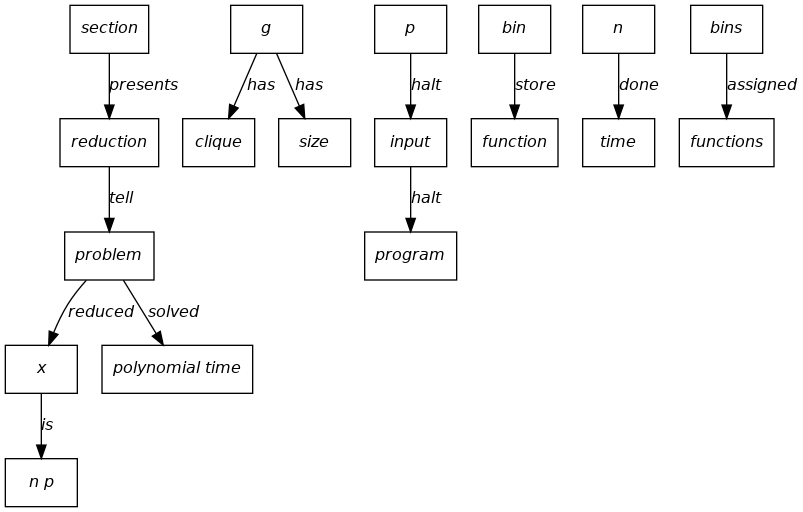

Cluster: #4, cluster chapters: [1, 13], chapter names: ['Mathematical Preliminaries', 'Analysis Techniques']


/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tf = pd.concat([tf, row_df], ignore_index=True)
/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  idf = pd.concat([idf, row_df], ignore_index=True)


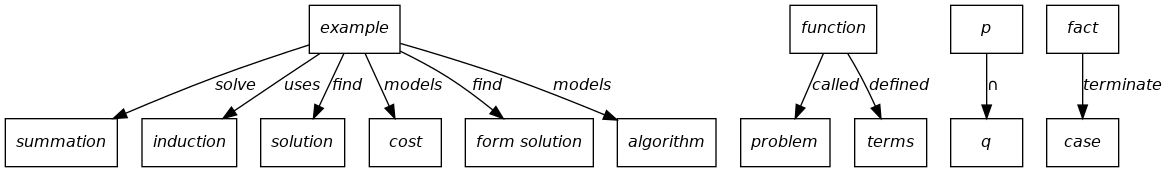

Cluster: #5, cluster chapters: [2, 6, 14], chapter names: ['Algorithm Analysis', 'Internal Sorting', 'Lower Bounds']


/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tf = pd.concat([tf, row_df], ignore_index=True)
/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  idf = pd.concat([idf, row_df], ignore_index=True)


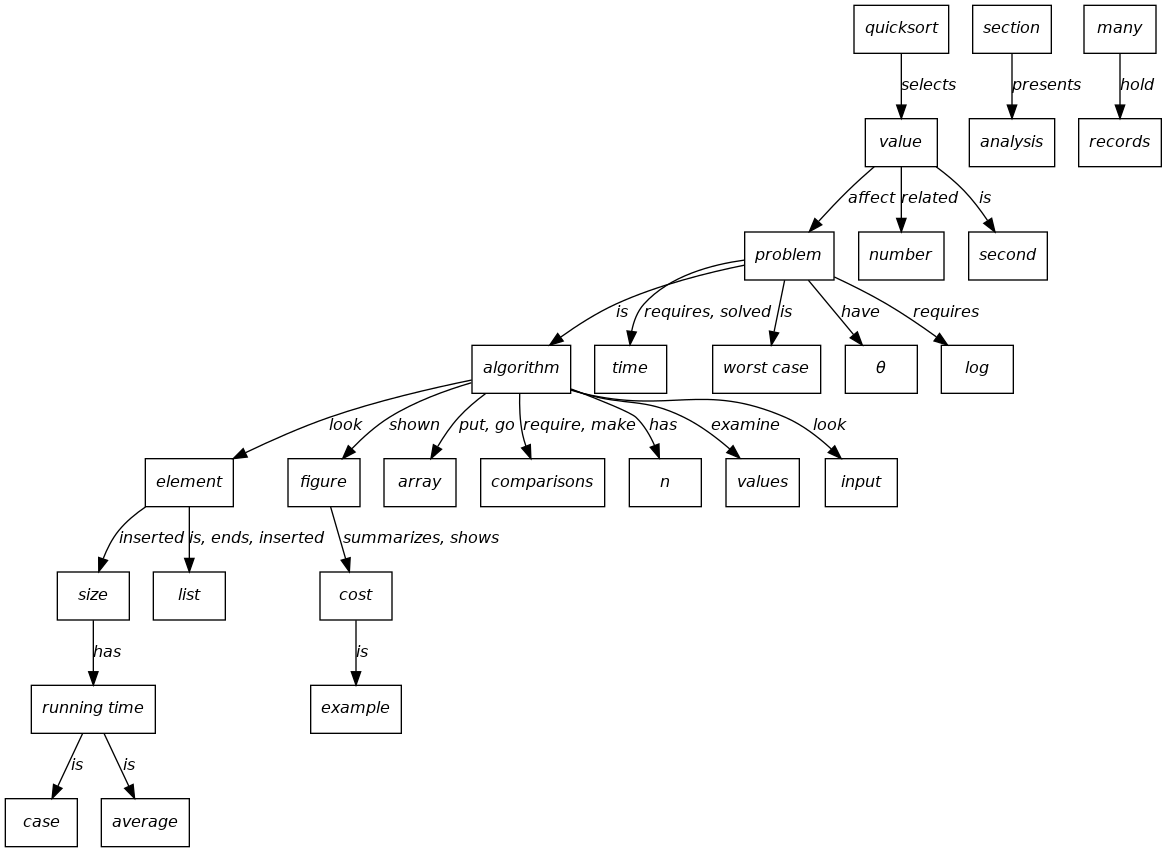

Cluster: #6, cluster chapters: [7, 11], chapter names: ['File Processing and External Sorting', 'Lists and Arrays Revisited']


/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tf = pd.concat([tf, row_df], ignore_index=True)
/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  idf = pd.concat([idf, row_df], ignore_index=True)


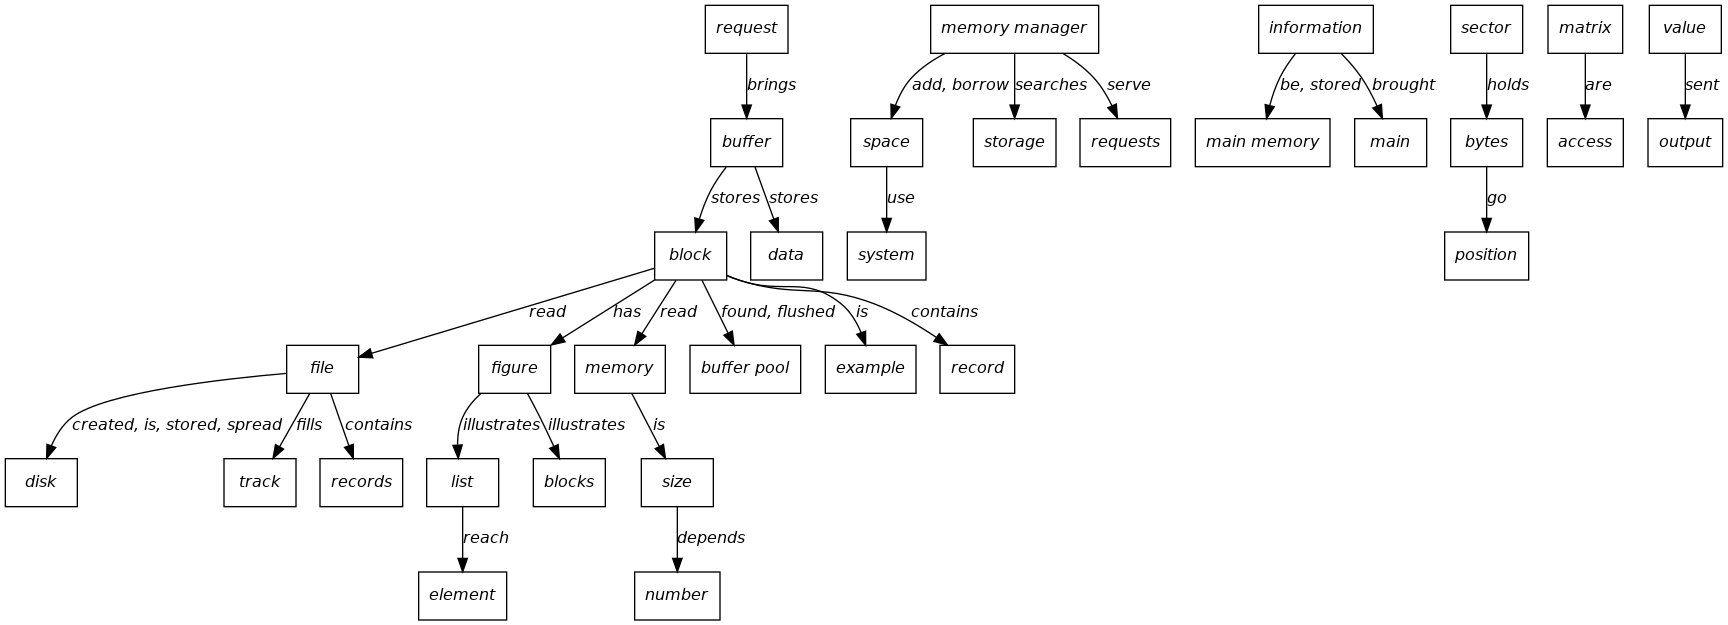

Cluster: #7, cluster chapters: [10], chapter names: ['Graphs']


/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tf = pd.concat([tf, row_df], ignore_index=True)
/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  idf = pd.concat([idf, row_df], ignore_index=True)


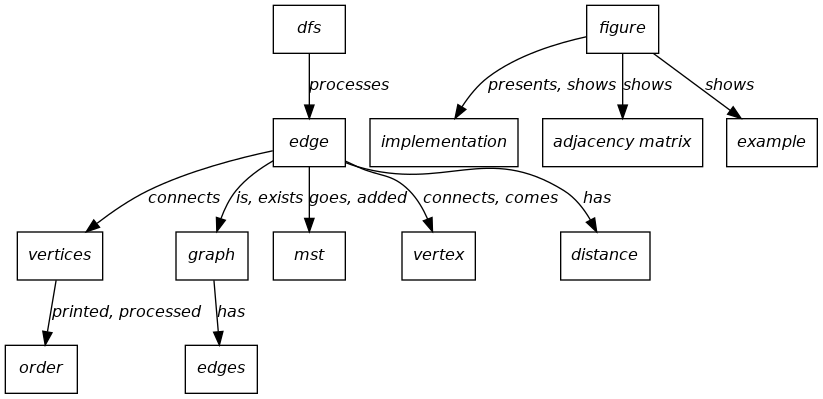

Cluster: #8, cluster chapters: [3], chapter names: ['Lists, Stacks, and Queues']


/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tf = pd.concat([tf, row_df], ignore_index=True)
/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  idf = pd.concat([idf, row_df], ignore_index=True)


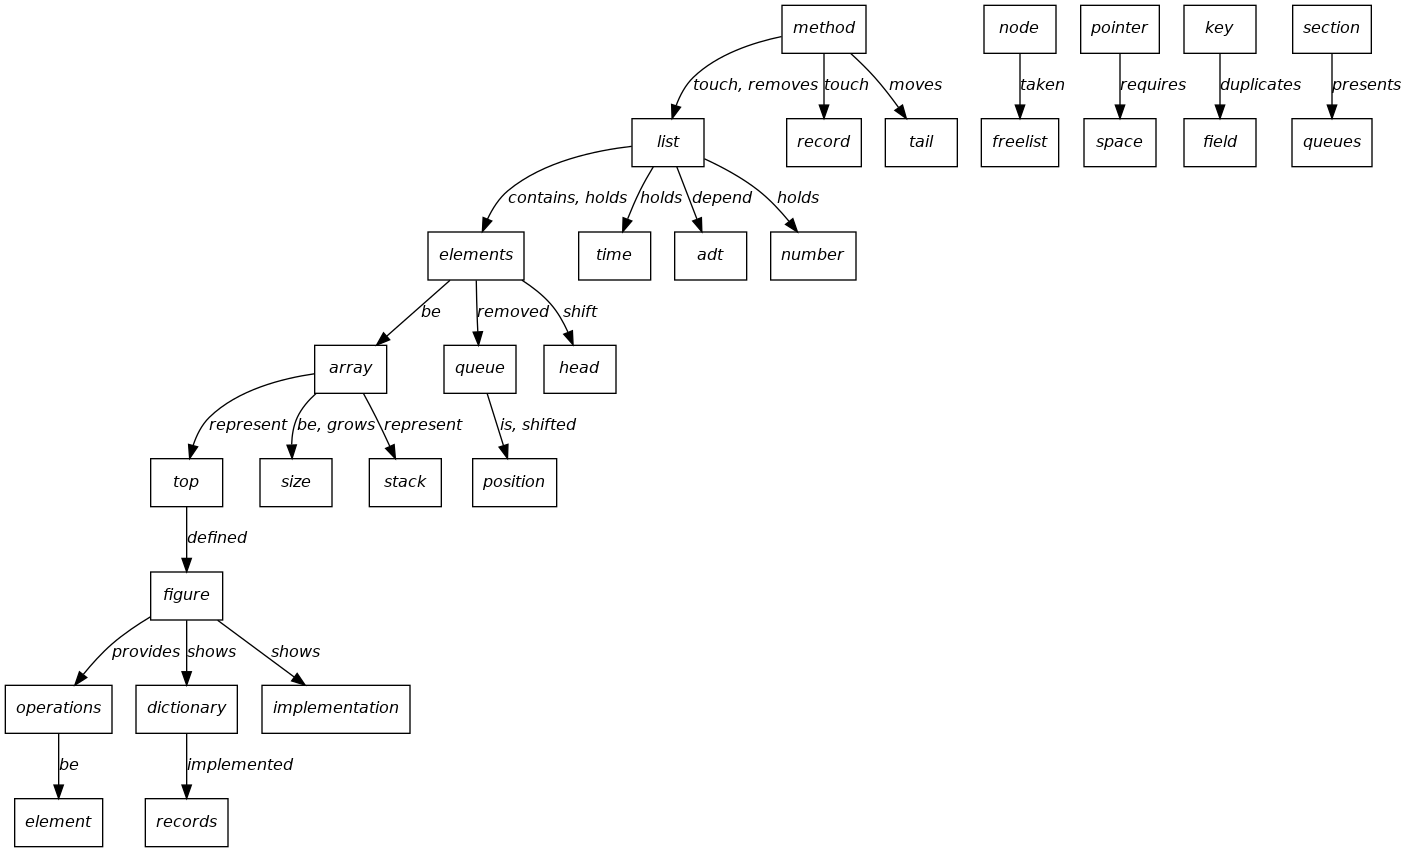

Cluster: #9, cluster chapters: [8], chapter names: ['Searching']


/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tf = pd.concat([tf, row_df], ignore_index=True)
/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  idf = pd.concat([idf, row_df], ignore_index=True)


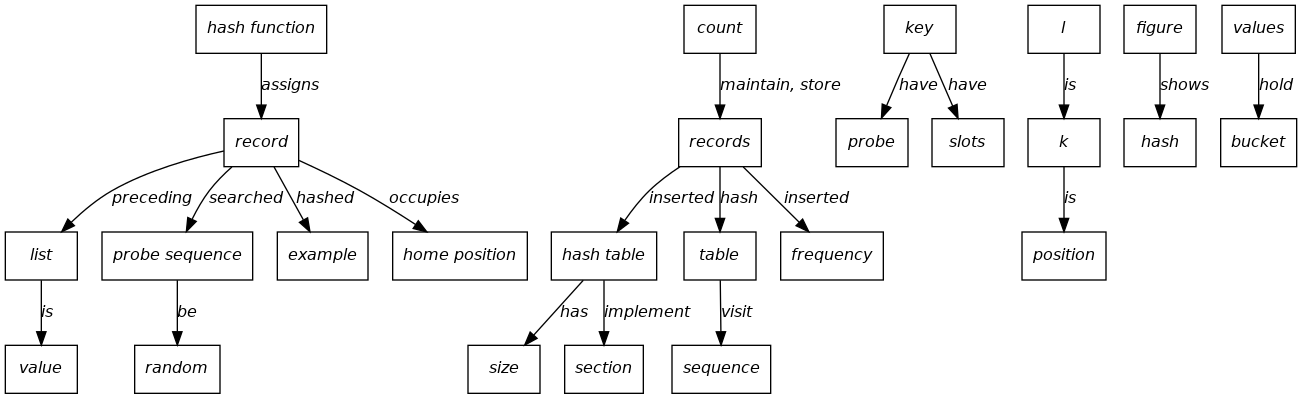

Cluster: #10, cluster chapters: [15], chapter names: ['Patterns of Algorithms']


/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tf = pd.concat([tf, row_df], ignore_index=True)
/home/zhutchens/uncc/research/hierarchical_clustering/concept_hierarchies/preprocessing.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  idf = pd.concat([idf, row_df], ignore_index=True)


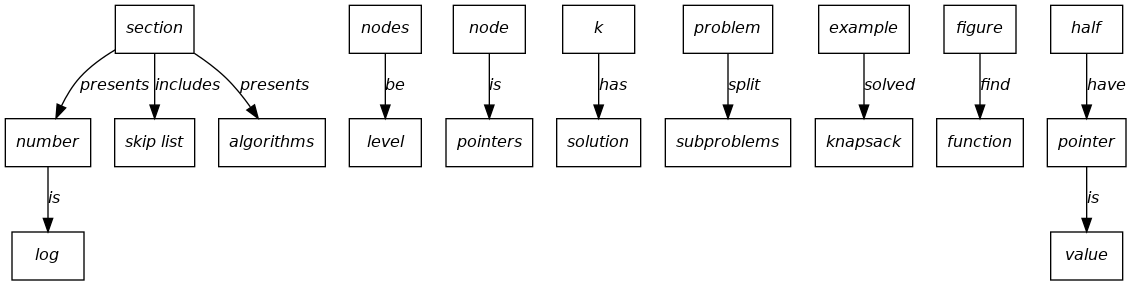

In [15]:
# Run for each cluster
for cluster in range(1, num_topics + 1):
    print(f'Cluster: #{cluster}, cluster chapters: {clusters[cluster]}, chapter names: {[chapter_titles[i] for i in clusters[cluster]]}')
    
    text_per_chapter = []
    for idx in clusters[cluster]:
        text_per_chapter.append(chapter_texts[idx])
    
    tf_idf_pre_filtering = get_word_types_with_tf_idf(
        text_per_chapter,
        "tf",
        skip_stopwords=True,
        include_verbs=False,
        include_determiners=False,
        include_pronouns=False,
        include_adverbs=False,
        include_numbers=False
    )
    
    #print(tf_idf_pre_filtering.head(50))
    
    top_n_words = tf_idf_pre_filtering.head(50)["word"].values
    
    all_verses = []
    for idx in clusters[cluster]:
        all_verses.extend(sentences_per_chapter[idx])
        
    directed_relations, relations_to_verbs = get_directed_relations(
        top_n_words=top_n_words,
        all_verses=all_verses,
        verbose=False,
    )
    
    ordered_directed_relations = order_directed_relations(
        directed_relations=directed_relations,
        tf_idf_pre_filtering=tf_idf_pre_filtering,
        order_by="product",
        include_ordering_wrt_occurences=True,
        verbose=False,
    )
    
    ontology_hierarchy, words_with_parents = construct_ontology_hierarchy(
        ordered_directed_relations=ordered_directed_relations,
    )
    
    draw_hierarchy_tree_from_ontology(
        ontological_hierarchy=ontology_hierarchy,
        relations_to_verbs=relations_to_verbs
    )